# Motor Vehicle Registrations by State

![Cloudy outdoor scene with a parking lot full of cars, most of them white](cars.jpg)

This project, I decided to search US government open data for a suitable dataset. After scrolling through various datasets, I found one that looked promising. The [Motor Vehicle Registrations Dashboard Data](https://catalog.data.gov/dataset/motor-vehicle-registrations-dashboard-data) is a dataset in which each row has car registration information for a given US state and year. What I liked about this dataset is that it had predefined categories and columns with numeric values.

The dataset tracks motor vehicle registration numbers, which roughly correlate to vehicle sales. My goal in this project would be to understand the distribution of cars sold by year, in order to get a sense of how high and low the yearly numbers have been in the course of the history of cars.

## Code Setup

In [1]:
import arviz as az
import math
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

In [2]:
df = pd.read_csv("motor-vehicle-registrations.csv"); df

,year,state,Auto,Bus,Truck,Motorcycle
0,1900,Alabama,40.0,0.0,0.0,0.0
1,1900,Alaska,0.0,0.0,0.0,0.0
2,1900,Arizona,20.0,0.0,0.0,0.0
3,1900,Arkansas,20.0,0.0,0.0,0.0
4,1900,California,780.0,0.0,0.0,0.0
...,...,...,...,...,...,...
6288,2020,Virginia,3057254.0,35463.0,4329294.0,184441.0
6289,2020,Washington (2),2800370.0,24172.0,4211411.0,221448.0
6290,2020,West Virginia (2),508663.0,3155.0,1102015.0,43529.0
6291,2020,Wisconsin (2),1901497.0,14941.0,3423523.0,276310.0


The dataset is pretty simple. Data is categorized by year and state. I will choose state for my hierarchical model, so that I can analyze trends for individual states. Next, I did some data preparation:

In [3]:
# I chose six states, which are the top 6 US states by population
df = df[df["state"].isin(["California", "Texas", "Florida", "New York", "Pennsylvania", "Illinois"])]

# An attempt to "fix" the dataset. See my explanation below.
df = df[df["year"] > 1960]

In [4]:
# This function calculates a new value in a row by summing the row's values
# of Auto, Bus, Truck, and Motorcycle.
def calculate_total(row):
    return row["Auto"] + row["Bus"] + row["Truck"] + row["Motorcycle"]

# I create a column called 'total' using the calculate_total function
df = df.assign(total=df.apply(calculate_total, axis=1))
# I tell pandas that the 'state' column is categorical.
df = df.astype({"state": "category"})
df

,year,state,Auto,Bus,Truck,Motorcycle,total
3118,1961,California,6892129.0,13145.0,1187383.0,87386.0,8180043.0
3123,1961,Florida,2124865.0,5910.0,317501.0,31442.0,2479718.0
3127,1961,Illinois,3388771.0,13205.0,456261.0,25611.0,3883848.0
3146,1961,New York,4630064.0,20429.0,549208.0,15757.0,5215458.0
3152,1961,Pennsylvania,3804749.0,13649.0,551686.0,29743.0,4399827.0
...,...,...,...,...,...,...,...
6246,2020,California,14201400.0,100828.0,15310597.0,785424.0,30398249.0
6251,2020,Florida,7841553.0,60173.0,9942703.0,620077.0,18464506.0
6274,2020,New York,4232748.0,81682.0,6625705.0,384620.0,11324755.0
6280,2020,Pennsylvania,4043715.0,55267.0,6230712.0,360493.0,10690187.0


## Data overview

For my numeric data, I decided to create a `total` column, composed of registration data for all vehicle categories. Next, I got a rough view of my data with Seaborn plots.

<Axes: xlabel='total', ylabel='state'>

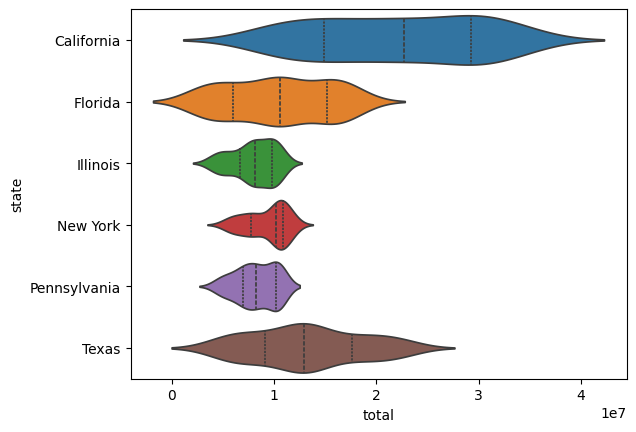

In [5]:
# A violin plot of the state data.
sns.violinplot(df, x="total", y="state", inner="quart", hue="state")

From the plots, one can tell that the distributions are not exactly similar or easily representable by one of the PyMC distributions. This was the first sign that the dataset may have been less ideal than I thought it would be.

The x-axis is plotted in ten millions. Generally, the distribution means are slightly above ten million, with California being a notable exception, with its range extending all the way to points with 30 million cars. When I first analyzed the dataset, I didn't really think about choosing states with similar populations. When I plotted the distributions, I realized that they were so different, that modelling them together would present issues. This is caused by US states being wildly different in terms of population and driving culture.

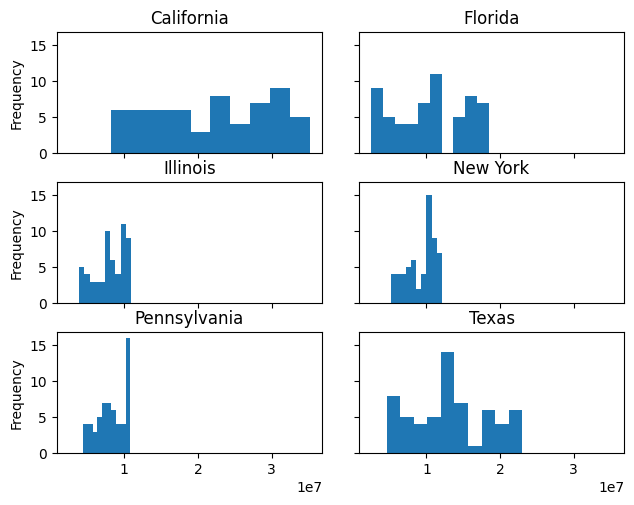

In [6]:
# Create a 3 row by 2 col grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
# Prevent subplot titles and axes from interfering with each other
fig.tight_layout()

# Iterate over the state names
for i, state in enumerate(df.state.cat.categories):
    # Fill in axes, from top to bottom, left to right
    ax = axes[math.floor(0.5 * i)][i % 2]
    # Label the graphs
    ax.set_title(state)
    # Plot the histogram for each state
    df[df["state"] == state]["total"].plot.hist(ax=ax)

Even for similar states in terms of poulation, the data distributions are wildly different. That being said, I moved on, believing that the general shape of each graph can be represented with a single distribution, with hyperpriors to allow certain parameters to influence each other.

## Models

Next, I decided to create a hierarchical and non-hierarchical model to see which would be better modelling reality.

### Choice of likelihood

My general assumptions about motor vehicle registration data are as following: Over time, as cars have gotten more popular, sales have increased rapidly and significantly. However, growth until that point happened over the course of decades. Thus, I expect the data to not be significantly be concentrated around a narrow range, and instead for there to be a significant amount of skew.

I decided to go with a `SkewStudentT` distribution, which has four parameters.

- mu ($\mu$): location parameter
- sigma ($\sigma$): squish-ness of the graph
- a, b: control skew

### Choice of prior

Below, I plotted interactive charts of different distributions to understand their parameters.

In [7]:
pz.SkewStudentT().plot_interactive()

interactive(children=(FloatSlider(value=0.0, description='mu (-inf, inf)', max=10.0, min=-10.0, style=SliderSt…

In [8]:
pz.Gamma().plot_interactive(xy_lim="auto")

interactive(children=(FloatSlider(value=2.0, description='alpha (0, inf)', max=12.0, min=2.220446049250313e-16…

In [9]:
pz.StudentT().plot_interactive()

interactive(children=(FloatSlider(value=7.0, description='nu (0, inf)', max=17.0, min=2.220446049250313e-16, s…

In [10]:
pz.HalfStudentT().plot_interactive()

interactive(children=(FloatSlider(value=7.0, description='nu (0, inf)', max=17.0, min=2.220446049250313e-16, s…

The trend between states that I noticed was that they varied mostly in terms of location of the mean and variance. These are controlled by $\mu$ and $\sigma$, so I decided do choose those two variables for hyperpriors. This left $a$ and $b$ to be modeled by just priors.

For $\mu$, I chose a `StudentT` distribution because I have low prior knowledge (Normal and Student's T introduce few assumptions) and my likelihood is `SkewStudentT`. For $\sigma$, I chose a HalfStudentT distribution due to the fact that sigma is a positive value and scale parameter. For both, I wanted a weak prior, so I chose default values of 0/1 for my hyperpriors (also because I wanted to test if the distribution would even work on first run).

For a and b, I used `Gamma` distributions to centralize my guess over specific values, such that $a$ and $b$ would likely skew right. This models my assumptions about the vehicle skew that I described earlier.

### Model

In [11]:
state_idx = df.state.cat.codes.values
state_codes = df.state.cat.categories
coords = {"state": state_codes}

In [12]:
with pm.Model(coords=coords) as model_hierarchical1:
    # Hyperpriors
    mu_mu = pm.StudentT("μ→μ", mu=0, sigma=1, nu=1)
    mu_sigma = pm.HalfStudentT("μ→σ", sigma=1, nu=1)
    mu_nu = pm.HalfStudentT("μ→ν", sigma=1, nu=1)
    sigma_sigma = pm.HalfStudentT("σ→σ", sigma=1, nu=1)
    sigma_nu = pm.HalfStudentT("σ→ν", sigma=1, nu=1)
    
    # Prior
    mu = pm.StudentT("μ", mu=mu_mu, sigma=mu_sigma, nu=mu_nu, dims="state")
    sigma = pm.HalfStudentT("σ", sigma=sigma_sigma, nu=sigma_nu, dims="state")
    a = pm.Gamma("a", alpha=8, beta=1, dims="state")
    b = pm.Gamma("b", alpha=2, beta=1, dims="state")
    
    # Likelihood
    y = pm.SkewStudentT("y",
                        mu=mu[state_idx],
                        sigma=sigma[state_idx],
                        a=a[state_idx],
                        b=b[state_idx],
                        observed=df["total"])
    
    data_hierarchical1 = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ→μ, μ→σ, μ→ν, σ→σ, σ→ν, μ, σ, a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1555 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


At first I thought the model was promising, considering there were no divergences, but ultimately it wen out of whack. The graphs and $\hat{R}$ values confirm that it is indeed broken.

/home/maxim/school/lasa/2024-2025/data-science/data-science-fundamentals/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ→μ'}>, <Axes: title={'center': 'μ→μ'}>],
       [<Axes: title={'center': 'μ→ν'}>, <Axes: title={'center': 'μ→ν'}>],
       [<Axes: title={'center': 'μ→σ'}>, <Axes: title={'center': 'μ→σ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ→ν'}>, <Axes: title={'center': 'σ→ν'}>],
       [<Axes: title={'center': 'σ→σ'}>, <Axes: title={'center': 'σ→σ'}>]],
      dtype=object)

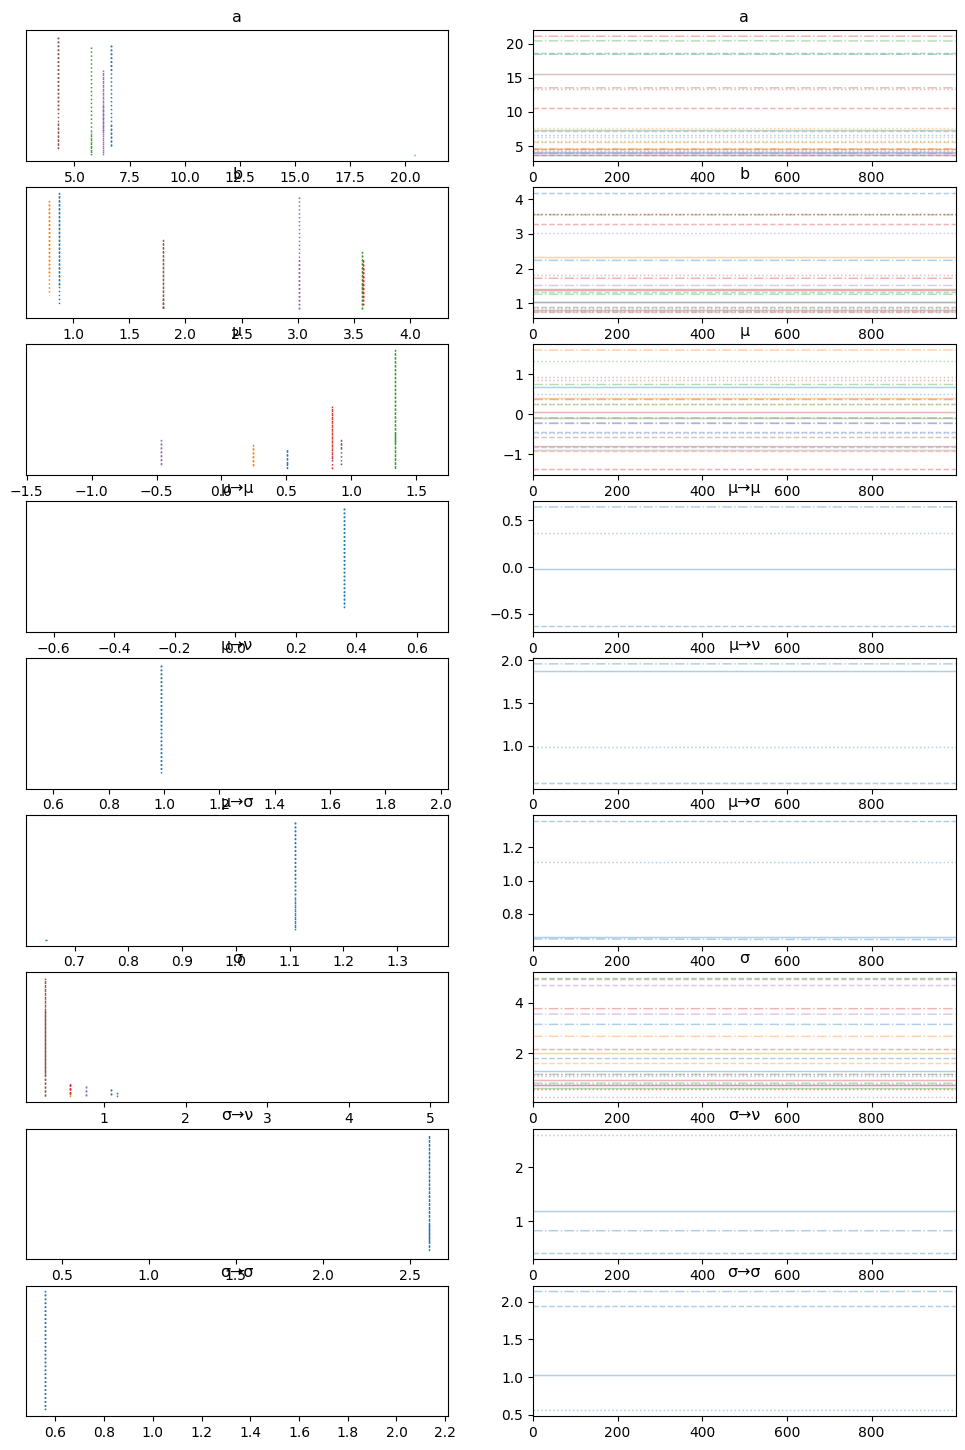

In [13]:
az.plot_trace(data_hierarchical1)

A warning was emitted during plotting: "Your data appears to have a single value or no finite values." Furthermore, the plot has straight, thin collections of points rather than the wavy graphs we usually see. This shows that the model has failed to capture a useful result.

In [15]:
az.rhat(data_hierarchical1)

<xarray.Dataset> Size: 520B
Dimensions:  (state: 6)
Coordinates:
  * state    (state) <U12 288B 'California' 'Florida' ... 'Pennsylvania' 'Texas'
Data variables:
    a        (state) float64 48B 3.411 3.206 3.545 3.573 3.496 3.971
    b        (state) float64 48B 4.281 3.303 4.111 4.053 3.2 3.338
    μ        (state) float64 48B 4.093 3.635 3.855 3.896 3.338 3.278
    μ→μ      float64 8B 3.584
    μ→ν      float64 8B 3.805
    μ→σ      float64 8B 4.056
    σ        (state) float64 48B 3.642 3.578 3.836 3.764 3.457 4.274
    σ→ν      float64 8B 3.358
    σ→σ      float64 8B 3.499

This is confirmed by the $\hat{R}$ values being *way* above 1. I then plotted a ridge plot, which to my surprise, looked way wavier than I had seen before:

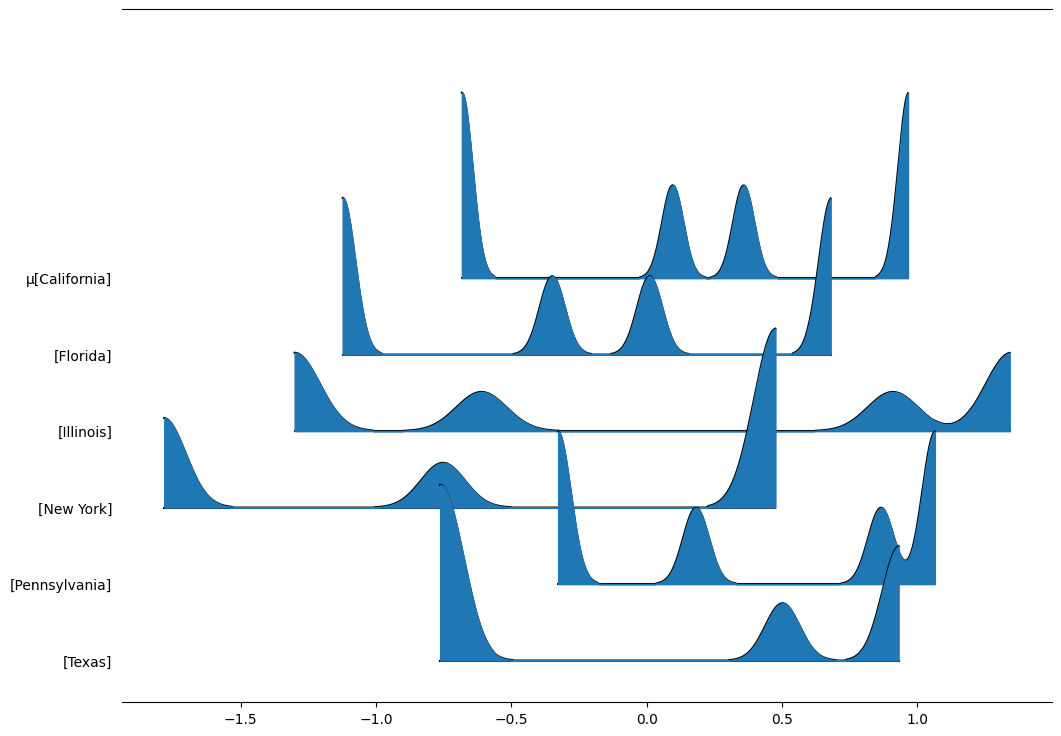

In [14]:
axes = az.plot_forest(data_hierarchical1, kind="ridgeplot",
                      var_names="μ",
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

At this point, I knew it was a fundamental issue with the model or the data. Divergences weren't really an issue. Instead, the reaching maximum tree depth, along with the graphs and $\hat{R}$ values, showed the extent of the problem. I believe that such results don't usually happen if a distribution just poorly fits the data when another could do better. In that case, the results show divergences, but there will still be a functioning result.

Things that I tried to mitigate this issue:

- I replotted multiple times with various subsets of the data set at different date ranges. Unfortunately, I couldn't find a range that wasn't strangely distributed. I settled on the range of 1960 onward, but even that didn't work all the way.
- I replotted without hyperpriors (see the code below). It still produced strange results.
- I tweaked parameters, but that really didn't do much.
- I tried different variations of hyperpriors. For example, I tried plotting only with the $\mu$ or only the $\sigma$ varaibles being hyperpriors. That produced similar (bad) results.

In [17]:
# This is a non-hierarchical model. It is a no-hyperprior version
# of the previous one in an attempt to get the model to work.
with pm.Model(coords=coords) as model_non_hierarchical1:
    # Prior
    sigma = pm.HalfStudentT("σ", sigma=1, nu=2, dims="state")
    mu = pm.StudentT("μ", mu=0, sigma=1, nu=1, dims="state")
    a = pm.Gamma("a", alpha=8, beta=1, dims="state")
    b = pm.Gamma("b", alpha=2, beta=1, dims="state")
    
    # Likelihood
    y = pm.SkewStudentT("y",
                        mu=mu[state_idx],
                        sigma=sigma[state_idx],
                        a=a[state_idx],
                        b=b[state_idx],
                        observed=df["total"])
    
    data_non_hierarchical1 = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1123 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


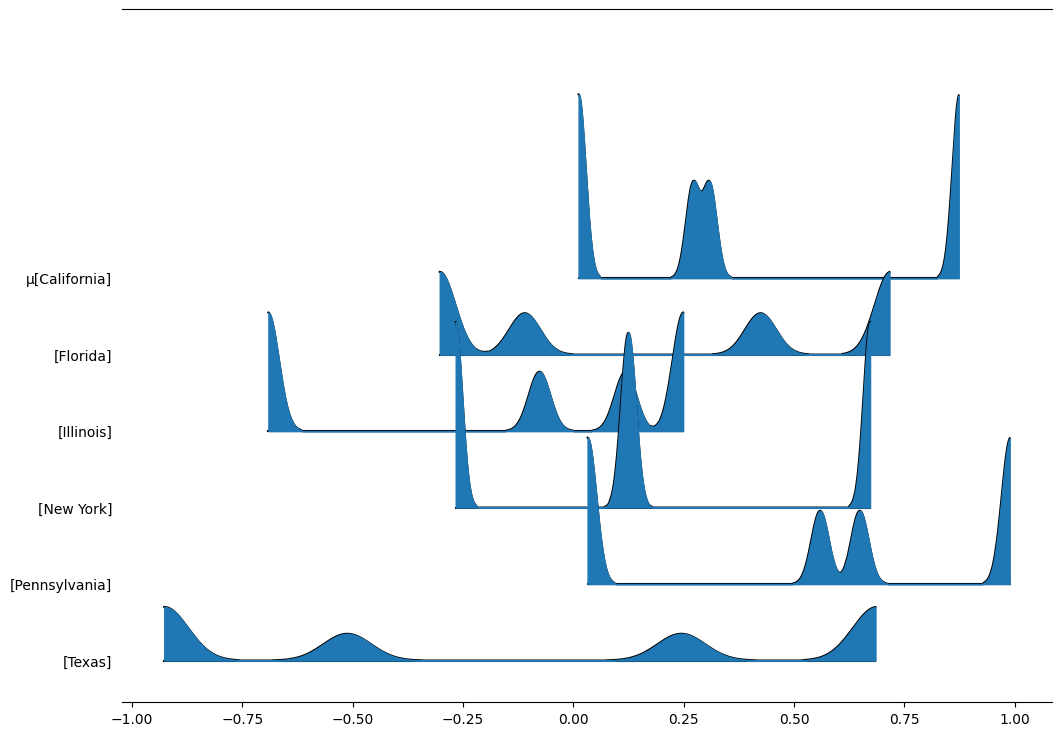

In [19]:
axes = az.plot_forest(data_non_hierarchical1, kind="ridgeplot",
                      var_names="μ",
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Even for the non-hierarchical model, the error persisted. This continued for all variations of models that I tried while attempting to narrow down what was causing the problem.

## Conclusion

Unfortunately, I ended up with no working model. I would have probably timkered with the data a bit more if I had the time. I found it bizarre that none of my attempts to change the model worked.

I think what probably caused this was the fact that the dataset is multimodal, and each category (state) is significantly different from the others. I also found no clear observable pattern between the different state, which means that the vehicle registration statistics have significant differences. This is probably due to the fact that each state calculates and manages registration in its own ways, has its own laws, and also has different-sized populations with differing needs.

In the future I need to vet my datasets more closely, because dataset choice has messed up my ability to get reasonable answers from the models more than once.